# Apply PSO on Matching Network Optimization
From separate code on PSO and Matching Network, it's time to merge these 2 to make an optimization for MN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

----------------------------------------------------------
## I. Define Matching Network

Still, suppose I have a MN of 5 component like this:

*-------------L2-------------------C3---------------C1---------------*

     |          |             |             |
           
    Z_out      L1             C2             Z_load
           
     |          |             |             |
      
*---------------------------------------------------------------------*

and Z_load is not matched at 50Ohm, so with help from MN, I expect to get Z_out matched

Let's try to simplify the parallel or series type of a circuit

In [2]:
def parallel(Z1, Z2):
    return 1/(1/Z1 + 1/Z2)

def series(Z1, Z2): 
    return Z1 + Z2

Then, I assign type (R/L/C), connection orientation (ser/par), lowest and highest values of 5 components, respectively:

In [3]:
num_component = 5

component_type = ('C', 'C', 'C', 'L', 'L')
component_topology = ('ser', 'par','ser', 'par','ser')
range_C = (1e-12, 100e-12)
range_distance_C = range_C[1] - range_C[0]
range_L = (1e-9, 100e-9)
range_distance_L = range_L[1] - range_L[0]

And the function to calculate output impedance from Z load and MN

*note: for component type: 0 - C, 1 - L, 2 - R; for component placement: 0 - series, 1 - parallel*

In [4]:
def out_impedance(num_component, components, freq, Z_load):
    Z = np.zeros((num_component+1,),dtype = complex)
    Z_out = np.zeros((num_component+1,),dtype = complex)
    # calculate impedance of each component
    Z[0] = Z_load
    #print (Z[0],end = '   ')
    for i in range(num_component):
        if components[i][0] == 0: # C
            Z[i+1] = 1/(1j*2*np.pi*freq*components[i][2])
        elif components[i][0] == 1: # L
            Z[i+1] = 1j*2*np.pi*freq*components[i][2]
        else: # R
            Z[i+1] = components[i][2]
    # calculate result
    Z_out[0] = Z_load
    for i in range(num_component):
        if components[i][1] == 0: # series
            Z_out[i+1] = series(Z_out[i], Z[i+1])
        else:                     # parallel
            Z_out[i+1] = parallel(Z_out[i], Z[i+1])
        #print ('\n Zout', i+1,' :', Z_out[i+1])
    return Z_out[num_component]

---------------------------------------------
## II. Apply PSO
General parameters of PSO are defined here, meaning of them is *PSOsinc* notebook


In [5]:
w = 0.3
c1 = 2
c2 = 2
max_iter = 1000
freq = 1e+9
Z_load = 20
Z0 = 50

### First step
Define the Solution Space

10 bees, or better-10 particles, will be assigned to the task to look for the best position in their so-called Solution Space. This space is 5D, as each agent needs 5 variables to define its location, seem unrealistic hah? :v

In [6]:
agent_quantity = 10
space_dimention = 5
agent_bound = np.zeros([num_component,2])
for i in range(space_dimention):
    if component_type[i] == 'C':
        agent_bound[i] = range_C
    else:
        agent_bound[i] = range_L
agent_bound

array([[1.e-12, 1.e-10],
       [1.e-12, 1.e-10],
       [1.e-12, 1.e-10],
       [1.e-09, 1.e-07],
       [1.e-09, 1.e-07]])

### Second step
Define a fitness function. In this case, it's the S11 at given frequency

In [7]:
def fitness(agent):
    components = np.zeros([num_component,3])
    for i in range(num_component):
        # Component type
        if component_type[i] == 'C':
            components[i][0] = 0 # C
        elif component_type[i] == 'L':
            components[i][0] = 1 # L
        else:
            components[i][0] = 1 # R
        # Component placement
        if component_topology[i] == 'ser':
            components[i][1] = 0
        else:
            components[i][1] = 1
        # Component value
        components[i][2] = agent[i]
        
    #print(components)
    Z_out = out_impedance(num_component, components, freq, Z_load)
    fitness = np.abs((Z_out - Z0)/(Z_out + Z0))
    return 1 - fitness
# Check fitness function
fitness([10e-12, 20e-12, 30e-12, 40e-9, 50e-9])

0.0015327902737268806

### Third step 
Initialize Random Swam Location and Velocities

In [8]:
agent_location = np.zeros([agent_quantity, space_dimention])
for i in range(space_dimention):
    if component_type[i] == 'C':
        for j in range(agent_quantity):
            agent_location[j][i] = range_distance_C*np.random.rand()+range_C[0]
    elif component_type[i] == 'L':
        for j in range(agent_quantity):
            agent_location[j][i] = range_distance_L*np.random.rand()+range_L[0]

agent_location

array([[2.03383543e-11, 3.92092068e-11, 1.34171893e-12, 7.91518731e-08,
        2.44024426e-08],
       [5.48132533e-11, 9.30961263e-11, 3.41257071e-11, 5.20681290e-08,
        9.73759757e-08],
       [2.39897202e-11, 7.66801794e-11, 9.03480937e-11, 8.28755832e-08,
        1.69112177e-08],
       [9.91647645e-11, 2.61158459e-11, 5.81380199e-11, 6.05105947e-08,
        5.21793791e-08],
       [6.18434721e-11, 7.31386591e-11, 3.71935054e-11, 5.34953099e-08,
        8.10327175e-08],
       [5.12662253e-11, 5.21509601e-11, 1.08876282e-11, 8.76656847e-08,
        4.55831498e-08],
       [7.04804519e-11, 4.79846917e-11, 8.84772814e-12, 3.20050150e-09,
        8.06631832e-08],
       [5.13803594e-11, 9.36802325e-11, 8.73947958e-11, 7.58340362e-08,
        3.12653268e-08],
       [9.07755480e-11, 6.23909610e-11, 5.59170773e-11, 2.47415928e-08,
        2.28519390e-08],
       [8.64555283e-11, 7.22065694e-11, 9.90091328e-11, 3.05861431e-08,
        6.05686852e-08]])

*pbest at first is also the first swam*

In [9]:
agent_pbest = agent_location

In [10]:
agent_velocity = np.zeros([agent_quantity, space_dimention])
for i in range(space_dimention):
    if component_type[i] == 'C':
        for j in range(agent_quantity):
            agent_velocity[j][i] = range_distance_C*np.random.rand()+range_C[0]
    elif component_type[i] == 'L':
        for j in range(agent_quantity):
            agent_velocity[j][i] = range_distance_L*np.random.rand()+range_L[0]

agent_velocity

array([[7.98605596e-11, 2.71528159e-11, 7.95194317e-11, 4.46408350e-08,
        1.88255714e-08],
       [8.35596759e-11, 6.96692804e-11, 6.18289739e-11, 2.75552464e-08,
        2.68672527e-08],
       [8.96512128e-11, 3.65481935e-11, 4.57432686e-11, 8.12140410e-08,
        7.81978692e-08],
       [1.04443418e-11, 3.14647904e-11, 1.78286792e-11, 1.93071014e-08,
        9.78125237e-08],
       [5.27669395e-11, 9.54809190e-11, 6.98528539e-11, 4.73811922e-08,
        1.66302613e-08],
       [7.28584619e-11, 9.04355303e-11, 8.81436165e-11, 3.89933681e-08,
        6.91799606e-08],
       [6.30793887e-12, 3.31337789e-11, 3.63290927e-11, 1.72812328e-08,
        8.74973761e-08],
       [8.55058155e-11, 1.57185993e-11, 7.30489536e-11, 3.68218923e-08,
        6.75764702e-08],
       [6.40143485e-11, 2.13464238e-11, 7.83375135e-11, 8.94616209e-08,
        6.71162135e-09],
       [7.44821837e-11, 8.66855812e-12, 9.68700037e-11, 9.53621385e-08,
        2.47028271e-08]])

### Fourth step
Systematically Fly the Particles Through the Solution Space

a) Evaluate the Particles's Fitness, Compare to gbest, pbest

In [11]:
agent_fitness = np.zeros([agent_quantity,1])
pbest = np.zeros([agent_quantity,1])

for i in range(0,agent_quantity):
    agent_fitness[i] = fitness(agent_location[i])
    if agent_fitness[i] > pbest[i]:
            pbest[i] = agent_fitness[i]
            agent_pbest[i] = agent_location[i]
    
pbest

array([[4.06747052e-02],
       [3.91057890e-05],
       [1.41206697e-03],
       [1.61438590e-03],
       [9.12894527e-05],
       [6.09116824e-04],
       [2.05059716e-02],
       [3.48569062e-04],
       [1.54520601e-03],
       [1.68096471e-04]])

In [12]:
gbest = np.zeros(1)
gbest[0] = pbest.max()
gbest_position = pbest.argmax()
print('\n Global best', gbest[0])
print('\n Global best position', gbest_position)
print('\n Agent at best position', agent_pbest[gbest_position])


 Global best 0.04067470524012384

 Global best position 0

 Agent at best position [2.03383543e-11 3.92092068e-11 1.34171893e-12 7.91518731e-08
 2.44024426e-08]


b) Update the Particle's velocity 

In [13]:
for i in range(agent_quantity):
    agent_velocity[i] = w*agent_velocity[i] + c1*np.random.rand()*(agent_pbest[i] - agent_location[i]) + c2*np.random.rand()*(agent_pbest[gbest_position]- agent_location[i])
    
agent_velocity

array([[ 2.39581679e-11,  8.14584478e-12,  2.38558295e-11,
         1.33922505e-08,  5.64767143e-09],
       [ 1.13358928e-11, -5.63403954e-13,  5.49020427e-12,
         1.90545459e-08, -2.10065746e-08],
       [ 2.67653485e-11,  9.63021760e-12,  1.05537032e-11,
         2.42316210e-08,  2.37261031e-08],
       [ 1.24399259e-13,  9.93922719e-12,  3.18061746e-12,
         6.50369147e-09,  2.82834765e-08],
       [-3.82064921e-11, -1.55293456e-11, -2.57205012e-11,
         4.76172933e-08, -6.87393241e-08],
       [ 2.06128883e-11,  2.66098358e-11,  2.60589228e-11,
         1.13553836e-08,  1.99015993e-08],
       [-6.16040107e-11, -1.17251731e-12,  1.39365067e-12,
         1.01363794e-07, -4.49953945e-08],
       [ 2.01644184e-11, -4.91331778e-12,  6.70299778e-12,
         1.16330650e-08,  1.90597822e-08],
       [-6.72710567e-11, -2.20561869e-11, -4.35006178e-11,
         9.36376927e-08,  3.91703126e-09],
       [-6.77662417e-11, -4.23714384e-11, -1.04049622e-10,
         9.47987283e-08

c) Move the particle

In [14]:
agent_location = agent_location + agent_velocity
for i in range(agent_quantity):
    for j in range(space_dimention):
        if agent_location[i][j] > agent_bound[j][1]:
            agent_location[i][j] = 2*agent_bound[j][1] - agent_location[i][j]
        if agent_location[i][j] < agent_bound[j][0]:
            agent_location[i][j] = 2*agent_bound[j][0] - agent_location[i][j]
        
agent_location

array([[4.42965221e-11, 4.73550516e-11, 2.51975484e-11, 9.25441236e-08,
        3.00501140e-08],
       [6.61491461e-11, 9.25327224e-11, 3.96159113e-11, 7.11226749e-08,
        7.63694011e-08],
       [5.07550687e-11, 8.63103970e-11, 9.90982031e-11, 9.28927958e-08,
        4.06373208e-08],
       [9.92891638e-11, 3.60550731e-11, 6.13186374e-11, 6.70142862e-08,
        8.04628556e-08],
       [2.36369800e-11, 5.76093136e-11, 1.14730043e-11, 9.88873969e-08,
        1.22933934e-08],
       [7.18791137e-11, 7.87607959e-11, 3.69465510e-11, 9.90210684e-08,
        6.54847491e-08],
       [8.87644120e-12, 4.68121744e-11, 1.02413788e-11, 9.54357042e-08,
        3.56677887e-08],
       [7.15447778e-11, 8.87669147e-11, 9.40977936e-11, 8.74671012e-08,
        5.03251090e-08],
       [2.35044913e-11, 4.03347741e-11, 1.24164595e-11, 8.16207145e-08,
        2.67689703e-08],
       [1.86892866e-11, 2.98351311e-11, 7.04048945e-12, 7.46151286e-08,
        1.86886706e-08]])

### Fifth step
Repeat everything in Step 4 untill iteration being out of range 

In [15]:
converge_flag = 0
for k in range(max_iter):
    if gbest[k] > 0.99:
        converge_flag = 1
        print('Converged!!! Hura!!')
        break
    # Step 4a
    for i in range(agent_quantity):
        agent_fitness[i] = fitness(agent_location[i])
        if agent_fitness[i] > pbest[i]:
            pbest[i] = agent_fitness[i]
            agent_pbest[i] = agent_location[i]
    
    gbest = np.append(gbest, pbest.max())
    gbest_position = pbest.argmax()
    # Step 4b
    for i in range(agent_quantity):
        agent_velocity[i] = w*agent_velocity[i] + c1*np.random.rand()*(agent_pbest[i] - agent_location[i]) + c2*np.random.rand()*(agent_pbest[gbest_position]- agent_location[i])
    
    # Step 4c
    agent_location = agent_location + agent_velocity
    for i in range(agent_quantity):
        for j in range(space_dimention):
            if agent_location[i][j] > agent_bound[j][1]:
                agent_location[i][j] = 2*agent_bound[j][1] - agent_location[i][j]
            if agent_location[i][j] < agent_bound[j][0]:
                agent_location[i][j] = 2*agent_bound[j][0] - agent_location[i][j]
    #print('Iteration: ', k)
    #print('Gbest in this iteration: ', gbest)

if converge_flag == 0:
    k +=1 
print('\n Agent at best position', agent_pbest[gbest_position])            
print('Gbest value is ', gbest[k])

Converged!!! Hura!!

 Agent at best position [5.23677076e-11 1.44965506e-12 2.80902587e-12 2.47973314e-08
 1.51387982e-08]
Gbest value is  0.9942099960987428


-----------------------------------------------------------
# III. Result
Final result is shown here, good or not, it've already taken a lot of time. Let's try to draw a graph to see the convergence progress

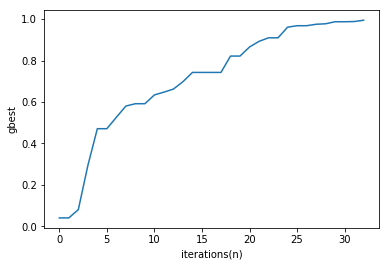

In [16]:
iterate = np.arange(k+1)
plt.plot(iterate,gbest)
plt.xlabel('iterations(n)')
plt.ylabel('gbest')
plt.show()

In [17]:
agent_gbest = agent_pbest[gbest_position]
components = np.zeros([num_component,3])
for i in range(num_component):
    # Component type
    if component_type[i] == 'C':
        components[i][0] = 0 # C
    elif component_type[i] == 'L':
        components[i][0] = 1 # L
    else:
        components[i][0] = 1 # R
    # Component placement
    if component_topology[i] == 'ser':
        components[i][1] = 0
    else:
        components[i][1] = 1
    # Component value
    components[i][2] = agent_gbest[i]
        
#print(components)
Z_out = out_impedance(num_component, components, freq, Z_load)
print('Z output is ', Z_out)

Z output is  (49.665019138385354-0.46988769772455896j)
